In [79]:
import pandas as pd 
import numpy as np
import joblib

import sbmlcore
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score,  roc_auc_score,  roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [127]:
data = pd.read_csv('data/ML_DATA_LEV.csv')
data.dropna(inplace= True)

#remove line below to train on samples rather than mutations
data.drop_duplicates(subset=['GENE_MUTATION'], keep='first', inplace=True)
data.GENE_MUTATION.value_counts()

GENE_MUTATION
gyrA_A90V     1
gyrB_K668R    1
gyrA_T164M    1
gyrA_Y379C    1
gyrB_G589V    1
             ..
gyrA_D488A    1
gyrA_P119L    1
gyrA_G477E    1
gyrB_A643D    1
gyrA_D94V     1
Name: count, Length: 163, dtype: int64

In [128]:
features = ['d_volume', 'd_hydropathy_KD', 'd_hydropathy_WW',
       'd_MW', 'd_Pi', 'secondary_structure', 'phi', 'psi', 'residue_sasa', 
       'n_hbond_acceptors', 'n_hbond_donors', 'SASA', 'snap2_score', 'dist_MGB', 'dist_MGE', 'dist_drug', 'temp_factor', 'depth', 'deep_ddG'] # 'B', 'C', 'E', 'G', 'H', 'T',

features = data[features]
features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
features.drop('secondary_structure', inplace = True, axis = 1)

/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_38418/812203343.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_38418/812203343.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop('secondary_structure', inplace = True, axis = 1)


In [129]:
features

,d_volume,d_hydropathy_KD,d_hydropathy_WW,d_MW,d_Pi,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,dist_MGB,dist_MGE,dist_drug,temp_factor,depth,deep_ddG,secondary_structure_codes
0,51.4,2.4,-0.86,28.0,-0.04,-61.83,-59.76,47.0,2.0,0.0,55.555816,-64.0,14.254302,5.504266,10.310827,40.439999,1.665078,0.089,0
1,82.5,2.2,-2.18,48.1,2.89,-58.04,-41.61,97.4,1.0,1.0,88.155089,81.0,18.193078,7.778979,14.095746,46.660000,1.733342,-0.376,0
2,3.0,0.0,-1.98,-1.0,2.64,-58.04,-41.61,97.4,1.0,1.0,88.155089,56.0,18.193078,7.778979,14.095746,46.660000,1.733342,-0.347,0
3,-3.0,0.0,1.98,1.0,-2.64,-66.66,120.50,43.0,2.0,2.0,40.444768,53.0,21.565351,18.549803,13.333886,62.860001,2.030527,-0.309,1
4,-25.1,2.7,-0.10,-27.0,0.27,-78.75,123.63,5.4,2.0,0.0,3.978588,-22.0,38.286533,31.644022,37.267766,50.119999,3.114263,-1.229,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,-50.6,-5.2,0.92,-12.1,-0.42,-130.11,149.27,24.8,0.0,0.0,25.392934,-40.0,27.224609,38.799515,38.672577,96.040001,1.915598,-1.102,5
1628,-64.9,7.0,-0.78,-53.0,-5.69,-58.30,-53.31,99.4,1.0,1.0,108.315927,-17.0,43.646112,41.821476,47.286371,59.320000,1.914005,-0.669,0
1656,-113.3,4.1,0.14,-99.1,-4.79,-79.33,120.91,123.9,1.0,0.0,117.789422,25.0,39.778686,31.598502,35.352796,61.540001,1.769443,-1.407,3
1706,-54.5,0.4,-1.38,-14.1,-4.33,-96.55,-13.55,131.0,0.0,1.0,129.497644,-54.0,29.899138,38.862500,33.061004,91.370003,1.615220,-0.314,4


In [130]:
y = data['CLEAN_BINARY_PHENOTYPE'].map({'S':0, 'R':1})
y

0       1
1       1
2       1
3       1
4       0
       ..
1623    0
1628    0
1656    0
1706    0
1717    1
Name: CLEAN_BINARY_PHENOTYPE, Length: 163, dtype: int64

In [131]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

score_dict = {}

for feature in features:
    print(f'Feature: {feature}')
    X = np.column_stack([np.ones(len(data), dtype=np.float32), features[feature].values])

    # Model fitting
    lr = LinearRegression()
    model_lr = lr.fit(X,y)
    print(f'R Squared: {model_lr.score(X,y)}')
    # Model coefficients
    print(f'intercept: {model_lr.intercept_} | coef: {model_lg.coef_}')

    # Model prediction
    lr_preds = model_lr.predict(X)
    #model.predict(new_x.reshape(1,-1)) # For new X value

    # Model Evaluation
    explained_variance = explained_variance_score(y,lr_preds) # explained variance = r2
    r_squared = r2_score(y,lr_preds) # r square
    mae = mean_absolute_error(y,lr_preds) # Mean absolute Percentage error
    mse = mean_squared_error(y,lr_preds) # Mean squared error
    #print(f'explained Var.: {explained_variance}\n\nR Square: {r_squared}\n\nMean Abs Error:{mae}\n\nMean Squared Error:{mse}')
    score_dict[feature] = [explained_variance, r_squared, mae, mse]

df = pd.DataFrame(score_dict, index=['explained_variance', 'r_squared', 'mae', 'mse']).T
df.sort_values(by='explained_variance', ascending=True, inplace=True)
df


Feature: d_volume
R Squared: 0.026868434505084804
intercept: 0.15460493566243963 | coef: [[ 1.76730686e-06 -5.98836691e-01]]
Feature: d_hydropathy_KD
R Squared: 0.00033367916275472975
intercept: 0.15118704686183373 | coef: [[ 1.76730686e-06 -5.98836691e-01]]
Feature: d_hydropathy_WW
R Squared: 0.02995511776595028
intercept: 0.13137938223959833 | coef: [[ 1.76730686e-06 -5.98836691e-01]]
Feature: d_MW
R Squared: 0.015664660785570717
intercept: 0.158108980658841 | coef: [[ 1.76730686e-06 -5.98836691e-01]]
Feature: d_Pi
R Squared: 0.0219554209224061
intercept: 0.15085513932274458 | coef: [[ 1.76730686e-06 -5.98836691e-01]]
Feature: phi
R Squared: 0.004880298595856258
intercept: 0.2076057712330096 | coef: [[ 1.76730686e-06 -5.98836691e-01]]
Feature: psi
R Squared: 0.007024456220815156
intercept: 0.16128516281925123 | coef: [[ 1.76730686e-06 -5.98836691e-01]]
Feature: residue_sasa
R Squared: 2.4885619647307955e-05
intercept: 0.15549500015286047 | coef: [[ 1.76730686e-06 -5.98836691e-01]]
Fe

,explained_variance,r_squared,mae,mse
n_hbond_donors,0.000011,0.000011,0.259698,0.129849
residue_sasa,0.000025,0.000025,0.259695,0.129847
SASA,0.000330,0.000330,0.259616,0.129808
d_hydropathy_KD,0.000334,0.000334,0.259614,0.129807
n_hbond_acceptors,0.002790,0.002790,0.258977,0.129488
phi,0.004880,0.004880,0.258434,0.129217
psi,0.007024,0.007024,0.257877,0.128938
depth,0.015336,0.015336,0.257268,0.127859
d_MW,0.015665,0.015665,0.255633,0.127817
deep_ddG,0.021555,0.021555,0.256114,0.127052


<Axes: >

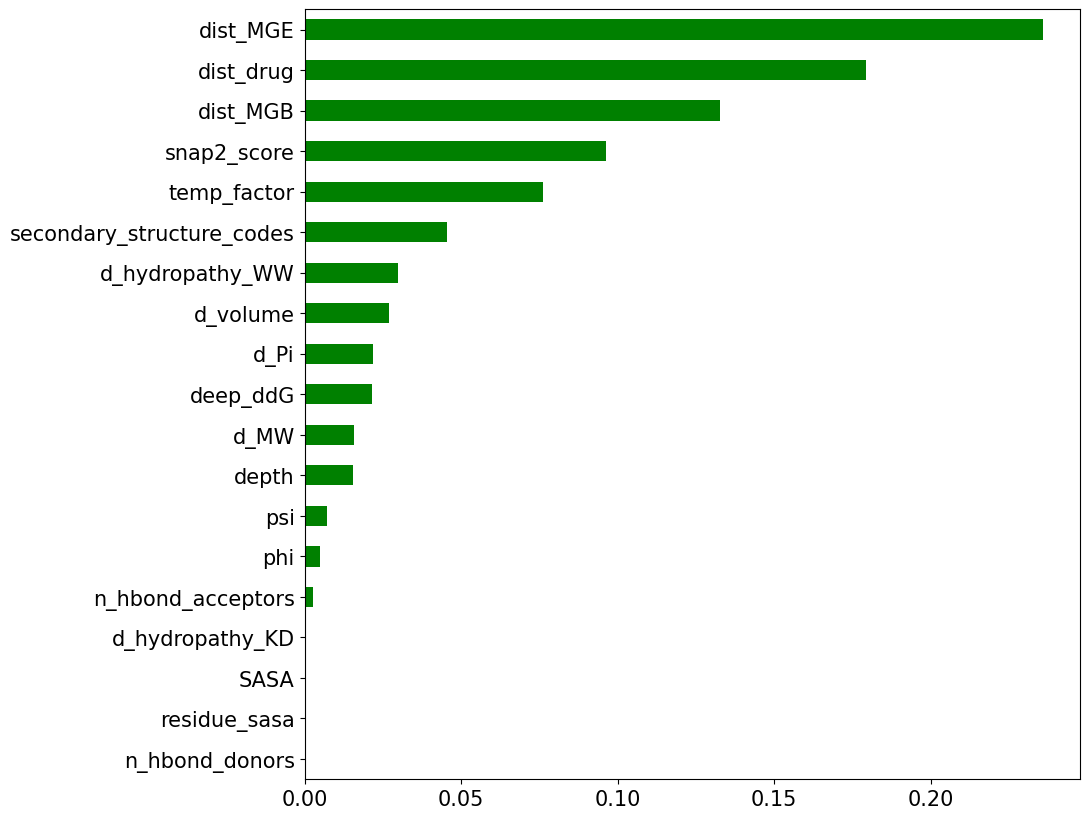

In [132]:
df.explained_variance.plot(kind='barh', figsize=(10,10), fontsize=15, color='green')

In [133]:
df.explained_variance[6:].sum()

0.9038697516513419

In [134]:
random_state=42
mutations ={}

df = data
mutations['tt'] = df.GENE_MUTATION
features = features
labels = df['CLEAN_BINARY_PHENOTYPE'].map({'S':0, 'R':1})
df['CLEAN_BINARY_PHENOTYPE'].value_counts()

CLEAN_BINARY_PHENOTYPE
S    138
R     25
Name: count, dtype: int64

In [135]:
mutations_train, mutations_test, X_train, X_test, Y_train, Y_test = train_test_split(mutations['tt'], features, labels, test_size=0.3,
                                                    random_state=random_state)
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

numerical_attribs = list(features)
numerical_attribs
headings = '\n'.join(i for i in numerical_attribs)

numerical_attribs

['d_volume',
 'd_hydropathy_KD',
 'd_hydropathy_WW',
 'd_MW',
 'd_Pi',
 'phi',
 'psi',
 'residue_sasa',
 'n_hbond_acceptors',
 'n_hbond_donors',
 'SASA',
 'snap2_score',
 'dist_MGB',
 'dist_MGE',
 'dist_drug',
 'temp_factor',
 'depth',
 'deep_ddG',
 'secondary_structure_codes']

In [136]:
pipe = Pipeline([
    ('selector', DataFrameSelector(numerical_attribs)),
    ('scaling', RobustScaler())
    ])

X_train = pipe.fit_transform(X_train)    
Y_train = Y_train.squeeze().to_numpy()
Z_train = mutations_train.to_numpy()

# let's save the pipeline to preserve the scaling etc
joblib.dump(pipe, 'data/pipeline.pkl')

X_test = pipe.transform(X_test)
Y_test = Y_test.squeeze().to_numpy()   
Z_test = mutations_test.to_numpy()
print(len(X_train), len(Y_train), len(Z_train))
print(len(X_test), len(Y_test), len(Z_test))

114 114 114
49 49 49


In [137]:
model_logistic_regression = LogisticRegression()

In [138]:
fpr = {}
tpr = {}
roc = {}
recall = {}

rows={}
rows['feature'] = []
rows['roc'] = []

Y_train_prepared = Y_train
X_train_prepared = X_train

for i in range(len(numerical_attribs)):

    attribute = numerical_attribs[i].rstrip()

    model_logistic_regression.fit(X_train_prepared[:,i:i+1], Y_train_prepared)

    Y_probs = cross_val_predict(model_logistic_regression, X_train_prepared[:,i:i+1], Y_train_prepared, cv=3, method='predict_proba', n_jobs=-1)
    
    Y_scores = Y_probs[:,1]

    # mask = (Y_scores>0.6) | (Y_scores<0.4)

    fpr[attribute], tpr[attribute], thresholds = roc_curve(Y_train_prepared, Y_scores)

    roc[attribute] = roc_auc_score(Y_train_prepared, Y_scores)

    Y_train_predicted = model_logistic_regression.predict(X_train_prepared[:,i:i+1])

    recall[attribute] = recall_score(Y_train_prepared, Y_train_predicted)

    rows['roc'].append(roc[attribute])
    rows['feature'].append(attribute)

    
df = pd.DataFrame(rows)
df.sort_values(by='roc', ascending=True, inplace=True)
df

,feature,roc
1,d_hydropathy_KD,0.354583
10,SASA,0.428571
7,residue_sasa,0.429595
6,psi,0.471582
2,d_hydropathy_WW,0.498208
9,n_hbond_donors,0.532770
8,n_hbond_acceptors,0.534050
0,d_volume,0.540963
16,depth,0.558116
17,deep_ddG,0.560676
